# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ../python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="../Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [4]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

#### 4.1 DDPG and MADDPG Algorithms

In this project, I use the DDPG algorithm (Deep Deterministic Policy Gradient) and the MADDPG algorithm,
a wrapper for DDPG. MADDPG stands for Multi-Agent DDPG. DDPG is an algorithm which concurrently learns
a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses
the Q-function to learn the policy. This dual mechanism is the actor-critic method. The DDPG algorithm uses
two additional mechanisms: Replay Buffer and Soft Updates.

In MADDPG, we train two separate agents, and the agents need to collaborate (like don’t let the ball hit the ground) and compete (like gather as many points as possible). Each agent’s critic is trained using the observations and actions from both agents , whereas each agent’s actor is trained using just its own observations.

#### 4.2 Training

After some experimentation, finally I have used the following hyperparameters:

```
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
EPSILON = 1.0           # for epsilon in the noise process (act step)
EPSILON_DECAY = 1e-6
```

In [6]:
!pip install config==0.4.2

In [5]:
import torch
from config import Config
from maddpg_agent import MADDPG
from collections import deque
import matplotlib.pyplot as plt

In [6]:
# config settings
config = Config()
config.update_every = 2
config.batch_size = 256
config.buffer_size = int(1e6)
config.discount = 0.99
config.tau = 2e-3
config.seed = 0
config.lr_actor = 1e-3
config.lr_critic = 1e-3
config.action_size = action_size
config.state_size = state_size
config.num_agents = num_agents
ma = MADDPG(config)

In [7]:
def train(n_episode=30000):
    """
    Function to train the agent
    """
    scores = []
    scores_window = deque(maxlen=100)
    for i_episode in range(n_episode):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        ma.reset()
        score = np.zeros(num_agents)
        while True:
            actions = ma.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            ma.step(states, actions, rewards, next_states, dones)
            score += rewards
            states = next_states
            if np.any(dones):
                break
        max_score = np.max(score)
        scores_window.append(max_score)
        scores.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.2f} Score: {:.2f} Critic Loss: {:-11.6f} Actor Loss: {:-10.4f}'.
              format(i_episode, np.mean(scores_window), max_score, ma.loss[0], ma.loss[1]),
              end="")
        # periodic model checkpoint
        if i_episode % 50 == 0:
            torch.save(ma.agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(ma.agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f} Critic Loss: {:-11.6f} Actor Loss: {:-10.4f} '
                  't_step {:-8d}'.
                  format(i_episode, np.mean(scores_window), ma.loss[0], ma.loss[1], ma.t_step))
        # Stopping the training after the avg score of 30 is reached
        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            torch.save(ma.agents[0].actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(ma.agents[0].critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

In [8]:
scores = train()

Episode 0	Average Score: 0.00 Critic Loss:    0.000000 Actor Loss:     0.0000 t_step       14
Episode 50	Average Score: 0.01 Critic Loss:    0.000021 Actor Loss:    -0.0526 t_step      787
Episode 100	Average Score: 0.00 Critic Loss:    0.000013 Actor Loss:    -0.0459 t_step     1497
Episode 150	Average Score: 0.00 Critic Loss:    0.000013 Actor Loss:    -0.0459 t_step     2252
Episode 200	Average Score: 0.00 Critic Loss:    0.000011 Actor Loss:    -0.0461 t_step     3002
Episode 250	Average Score: 0.00 Critic Loss:    0.000007 Actor Loss:    -0.0432 t_step     3711
Episode 300	Average Score: 0.00 Critic Loss:    0.000009 Actor Loss:    -0.0385 t_step     4421
Episode 350	Average Score: 0.01 Critic Loss:    0.000014 Actor Loss:    -0.0343 t_step     5244
Episode 400	Average Score: 0.01 Critic Loss:    0.000022 Actor Loss:    -0.0336 t_step     5992
Episode 450	Average Score: 0.00 Critic Loss:    0.000015 Actor Loss:    -0.0314 t_step     6714
Episode 500	Average Score: 0.02 Critic Loss

#### 4.3 Training plot
The agent was able to solve the environment by achieving score of 30.0 over 100 consecutive episodes after 165 episodes.

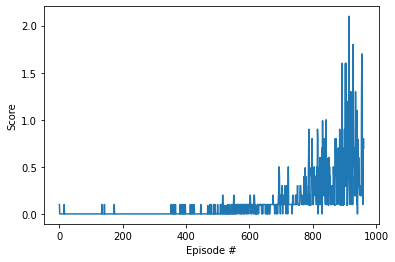

In [9]:
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
env.close()

### 5. Future ideas to improve the agent's performance

* DDPG can be improved by using prioritized experience replay. 
* Fine-tuning of hperparameters can also lead to better results and faster training time.